# Look At fold versus momentum

at a given attitude I want to see the effect of changing the fold angle on the moment about the hinge. To do this I will

- calcualte the attitude for a given set of cruise conditions
- calculate the moment about the hinge at different fold angles

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [2]:
def Model_Eigen_WT(model_num,b_modes,t_modes,angles):
    dataset_name = 'WT'
    p = rw.base_params(b_modes + t_modes + 2)
    p.rho.value = 1.225
    p.s_t.value = 1.345
    p.c.value = 0.15
    p.EI.value = 61
    p.GJ.value = 200
    p.rho_t.value = 10
    p.e_0.value = 0
    p.e_1.value = 0
    p.ratio_fwt.value = 0.2
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    
    vars_ls =[]
    vars_ls.append((p.V,[10,15,20]))
    vars_ls.append((p.alpha_r,np.deg2rad([1,3,5])))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))
    vars_ls.append((p.c_dmax,[0,1]))
    vars_ls.append((p.k_fwt,[0,1e5]))
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    
    
    print(f'M{model_num}-{dataset_name}: Started')
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    variables = [k for k,v in vars_ls]
    sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))
    L = me.msubs((sm_mini.ExtForces.Q()[0]),{i:0 for i in p.qd})
    L_func = sym.lambdify((p.q,variables),L)
    
    data = rw.fixed_point_finder(p,sm,vars_ls,True,additional_func={'Lift':L_func})
    print(f'M{model_num}-{dataset_name}: Found Fixed Points')
    Mom = me.msubs((sm_mini.ExtForces.Q()[-1]-sm_mini.f[-1]),{i:0 for i in p.qd})
    Mom_func = sym.lambdify((p.q,p.GetTuple()),Mom)
    res=[]
    for i in range(len(data)):
        fp_dict = data.iloc[i].to_dict()       
        #tup = p.GetTuple()
        for k,v in fp_dict.items():
            for s in p.GetTuple():
                if isinstance(s,mf.ModelSymbol):
                    if s.name == k:
                        s.value = v
        tup = p.GetNumericTuple(None,None) 
        _q = fp_dict['q']
        for ang in angles:
            _q[-1] = ang
            _res = Mom_func(_q,tup)
            res.append({**fp_dict,'attitude':i,'theta_c':ang,"Moment":_res,
                        "Config":dataset_name,"Model":model_num})
    print(f'M{model_num}-{dataset_name}: Complete')
    return res

In [3]:
def Model_Eigen_HALE(model_num,b_modes,t_modes,angles):
    dataset_name = 'HALE'
    p = rw.base_params(b_modes + t_modes + 2)
    p.rho.value = 0.0889
    p.s_t.value = 16
    p.c.value = 1
    p.EI.value = 2e4
    p.GJ.value = 1e4
    p.rho_t.value = 0.75
    p.e_0.value = 0.25
    p.e_1.value = 0
    
    p.ratio_fwt.value = 0.2
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    
    vars_ls =[]
    vars_ls.append((p.V,[15,20,25]))
    vars_ls.append((p.alpha_r,np.deg2rad([1,3,5])))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))
    vars_ls.append((p.c_dmax,[0,1]))
    vars_ls.append((p.k_fwt,[0,1e6]))
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    
    print(f'M{model_num}-{dataset_name}: Started')
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    variables = [k for k,v in vars_ls]
    sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))
    L = me.msubs((sm_mini.ExtForces.Q()[0]),{i:0 for i in p.qd})
    L_func = sym.lambdify((p.q,variables),L)
    
    data = rw.fixed_point_finder(p,sm,vars_ls,True,additional_func={'Lift':L_func})
    print(f'M{model_num}-{dataset_name}: Found Fixed Points')
    Mom = me.msubs((sm_mini.ExtForces.Q()[-1]-sm_mini.f[-1]),{i:0 for i in p.qd})
    Mom_func = sym.lambdify((p.q,p.GetTuple()),Mom)
    res=[]
    for i in range(len(data)):
        fp_dict = data.iloc[i].to_dict()       
        #tup = p.GetTuple()
        for k,v in fp_dict.items():
            for s in p.GetTuple():
                if isinstance(s,mf.ModelSymbol):
                    if s.name == k:
                        s.value = v
        tup = p.GetNumericTuple(None,None) 
        _q = fp_dict['q']
        for ang in angles:
            _q[-1] = ang
            _res = Mom_func(_q,tup)
            res.append({**fp_dict,'attitude':i,'theta_c':ang,"Moment":_res,
                        "Config":dataset_name,"Model":model_num})
    print(f'M{model_num}-{dataset_name}: Complete')
    return res

In [4]:
def Model_Eigen_JEC(model_num,b_modes,t_modes,angles):
    dataset_name = 'JEC'
    p = rw.base_params(b_modes + t_modes + 2)
    p.rho.value = 1.225
    p.s_t.value = 12
    p.c.value = 1.8
    p.EI.value = 9.77e6
    p.GJ.value = 0.99e6
    p.rho_t.value = 19.53
    p.e_0.value = 0.08
    p.e_1.value = 0  
    p.ratio_fwt.value = 0.2
    
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    p.k_fwt.value = 0
    
    vars_ls =[] 
    vars_ls.append((p.V,[30,40,50]))
    vars_ls.append((p.alpha_r,np.deg2rad([1,3,5])))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))
    vars_ls.append((p.c_dmax,[0,1]))
    vars_ls.append((p.k_fwt,[0,1e7]))
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    
    print(f'M{model_num}-{dataset_name}: Started')
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    variables = [k for k,v in vars_ls]
    sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))
    L = me.msubs((sm_mini.ExtForces.Q()[0]),{i:0 for i in p.qd})
    L_func = sym.lambdify((p.q,variables),L)
    
    data = rw.fixed_point_finder(p,sm,vars_ls,True,additional_func={'Lift':L_func})
    print(f'M{model_num}-{dataset_name}: Found Fixed Points')
    Mom = me.msubs((sm_mini.ExtForces.Q()[-1]-sm_mini.f[-1]),{i:0 for i in p.qd})
    Mom_func = sym.lambdify((p.q,p.GetTuple()),Mom)
    res=[]
    for i in range(len(data)):
        fp_dict = data.iloc[i].to_dict()       
        #tup = p.GetTuple()
        for k,v in fp_dict.items():
            for s in p.GetTuple():
                if isinstance(s,mf.ModelSymbol):
                    if s.name == k:
                        s.value = v
        tup = p.GetNumericTuple(None,None) 
        _q = fp_dict['q']
        for ang in angles:
            _q[-1] = ang
            _res = Mom_func(_q,tup)
            res.append({**fp_dict,'attitude':i,'theta_c':ang,"Moment":_res,
                        "Config":dataset_name,"Model":model_num})
    print(f'M{model_num}-{dataset_name}: Complete')
    return res

In [7]:
res = Model_Eigen_JEC(0,3,3,np.deg2rad(np.linspace(-90,90,7)))

M0-JEC: Started
M0-JEC: Found Fixed Points
M0-JEC: Complete


In [6]:
%%time
b_modes = 3
t_modes = 3
pool = mp.Pool(mp.cpu_count())

angs = np.deg2rad(np.linspace(-170,170,69))

res = []
for k in [0]:
    res.append(pool.apply_async(Model_Eigen_JEC,args=(k,b_modes,t_modes,angs)))
    res.append(pool.apply_async(Model_Eigen_HALE,args=(k,b_modes,t_modes,angs)))
    res.append(pool.apply_async(Model_Eigen_WT,args=(k,b_modes,t_modes,angs)))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
fixed_df = pd.DataFrame(ls)
print('Complete')

M0-HALE: Started
M0-JEC: Started
M0-WT: Started
M0-JEC: Found Fixed Points
M0-WT: Found Fixed Points
M0-JEC: Complete
M0-WT: Complete
M0-HALE: Found Fixed Points
M0-HALE: Complete
Complete
CPU times: user 511 ms, sys: 126 ms, total: 637 ms
Wall time: 2min 53s


In [8]:
fixed_df.to_pickle('CoastAngleVariation.pkl')
pd.DataFrame(ls).head()

,V,alpha_r,delta_m,c_dmax,k_fwt,Lambda,Lift,q,attitude,theta_c,Moment,Config,Model
0,30.0,0.017453,0.5,0.0,0.0,0.174533,1824.951989,"[-0.0018995440033603326, -0.000417515953601412...",0,-2.967060,-142.734616,JEC,0
1,30.0,0.017453,0.5,0.0,0.0,0.174533,1824.951989,"[-0.0018995440033603326, -0.000417515953601412...",0,-2.879793,-41.725069,JEC,0
2,30.0,0.017453,0.5,0.0,0.0,0.174533,1824.951989,"[-0.0018995440033603326, -0.000417515953601412...",0,-2.792527,58.860496,JEC,0
3,30.0,0.017453,0.5,0.0,0.0,0.174533,1824.951989,"[-0.0018995440033603326, -0.000417515953601412...",0,-2.705260,158.191787,JEC,0
4,30.0,0.017453,0.5,0.0,0.0,0.174533,1824.951989,"[-0.0018995440033603326, -0.000417515953601412...",0,-2.617994,255.494003,JEC,0


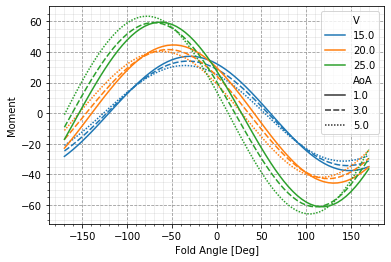

In [38]:
df=pd.DataFrame(ls)
df['V'] = pd.Categorical(df['V'])
df['AoA'] = pd.Categorical(np.round(np.rad2deg(df['alpha_r'])))
df['Fold Angle [Deg]'] = np.rad2deg(df['theta_c'])
#df = df[df['V']==30]
#df = df[df['alpha_r']==np.deg2rad(1)]
df = df[df['delta_m']==1]
df = df[df['c_dmax']==1]
df = df[df['k_fwt']==0]
df = df[df['Config']=='HALE']
df = df[df['Lambda']==np.deg2rad(10)]
ax = sns.lineplot(data = df,x='Fold Angle [Deg]',y='Moment',hue = 'V',style = 'AoA')


ax.grid(b=True, which='major', color='#999999', linestyle='--')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    


In [10]:
b_modes = 3
t_modes = 3
pool = mp.Pool(mp.cpu_count())

for k in [0,1,2,3,4,5]:
    pool.apply_async(Model_Eigen_JEC,args=(k,b_modes,t_modes))
    pool.apply_async(Model_Eigen_HALE,args=(k,b_modes,t_modes))
    pool.apply_async(Model_Eigen_WT,args=(k,b_modes,t_modes))
pool.close()
pool.join()

M0-HALE: Started
M1-JEC: Started
M2-JEC: Started
M1-WT: Started
M1-HALE: Started
M0-JEC: Started
M0-WT: Started
M2-HALE: Started
M2-JEC: Complete
M2-WT: Started
M2-WT: Complete
M3-JEC: Started
M1-WT: Complete
M3-HALE: Started
M1-JEC: Complete
M3-WT: Started
M2-HALE: Complete
M4-JEC: Started
M4-JEC: Complete
M4-HALE: Started
M3-JEC: Complete
M4-WT: Started
M0-JEC: Complete
M5-JEC: Started
M0-WT: Complete
M5-HALE: Started
M3-WT: Complete
M5-WT: Started
M1-HALE: Complete
M4-WT: Complete
M5-JEC: Complete
M0-HALE: Complete
M3-HALE: Complete
M5-WT: Complete
M4-HALE: Complete
M5-HALE: Complete


In [3]:
%%time
b_modes = 3
t_modes = 3
Model_Eigen_WT(5,3,3)

M5-WT: Started
M5-WT: Complete
CPU times: user 1min 5s, sys: 480 ms, total: 1min 5s
Wall time: 1min 6s


In [ ]:
df = pd.read_pickle(f'fp_data_{b_modes}B{t_modes}T-M5_WT.pkl')
df.head(5)